In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud
from textwrap import wrap
import unicodedata


# "..\Data\Banco-Preguntas-Icfes.txt"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
file_path = "../Data/Banco-Preguntas-Icfes.txt"

# Leer el archivo línea por línea
with open(file_path, "r", encoding="utf-8") as file:
    lines = file.readlines()

# Mostrar las primeras 10 líneas para verificar el formato
print("Contenido del archivo (primeras 10 líneas):\n")
for i, line in enumerate(lines[:10]):
    print(f"Línea {i+1}: {line.strip()}")


Contenido del archivo (primeras 10 líneas):

Línea 1: Pregunta: ¿En qué fechas se dará inicio al proceso de registro e inscripción a los exámenes?
Línea 2: Respuesta: Validar en la página www.icfes.gov.co / Evaluaciones y Elija el examen de su interés.
Línea 3: 
Línea 4: Pregunta:¿Cómo puedo cambiar el correo de notificaciones asociado al usuario PRISMA de mi sede jornada?
Línea 5: Respuesta:A través del Chat, ingresando a la  página www.icfes.gov.co / Atención y servicios a la ciudadanía / canales de atención / Chat.(Link:https://www.icfes.gov.co/atencion-y-servicios-a-la-ciudadania/canales-de-atencion/)
Línea 6: 
Línea 7: Pregunta:¿qué debo hacer para presentar las pruebas icfes por segunda vez?
Línea 8: Respuesta:Se puede registrar las veces que desee, después de la quinta inscripción la tarifa aumenta, validar en  la página www.icfes.gov.co / Evaluaciones y Elija el examen de su interés.
Línea 9: 
Línea 10: Pregunta:¿El examen saber 11°, entrega certificado o constancia de asistenc

In [24]:
# 📌 1️⃣ Inicializar listas para almacenar preguntas y respuestas
preguntas = []
respuestas = []
pregunta_actual = ""
respuesta_actual = ""
leyendo_respuesta = False

# 📌 2️⃣ Leer el archivo línea por línea y separar preguntas y respuestas
with open(file_path, "r", encoding="utf-8") as file:
    for line in file:
        line = line.strip()

        # Detectar preguntas
        if line.startswith("Pregunta:"):
            if pregunta_actual:
                preguntas.append(pregunta_actual.strip())
                respuestas.append(respuesta_actual.strip())
            pregunta_actual = line.replace("Pregunta:", "").strip()
            respuesta_actual = ""
            leyendo_respuesta = False

        # Detectar respuestas
        elif line.startswith("Respuesta:"):
            leyendo_respuesta = True
            respuesta_actual = line.replace("Respuesta:", "").strip()

        # Agregar contenido a la pregunta o respuesta
        else:
            if leyendo_respuesta:
                respuesta_actual += " " + line.strip()
            else:
                pregunta_actual += " " + line.strip()

# 📌 3️⃣ Agregar la última pregunta y respuesta
if pregunta_actual:
    preguntas.append(pregunta_actual.strip())
    respuestas.append(respuesta_actual.strip())

# 📌 4️⃣ Crear DataFrames separados para preguntas y respuestas
df_preguntas = pd.DataFrame({"Pregunta": preguntas})
df_respuestas = pd.DataFrame({"Respuesta": respuestas})

# 📌 5️⃣ Mostrar las primeras filas de cada DataFrame
print("\n📊 Primeras preguntas extraídas:")
print(df_preguntas.head())

print("\n📊 Primeras respuestas extraídas:")
print(df_respuestas.head())

# 📌 6️⃣ Mostrar el número total de preguntas y respuestas extraídas
print(f"\nTotal de preguntas extraídas: {len(df_preguntas)}")
print(f"Total de respuestas extraídas: {len(df_respuestas)}")


📊 Primeras preguntas extraídas:
                                            Pregunta
0  ¿En qué fechas se dará inicio al proceso de re...
1  ¿Cómo puedo cambiar el correo de notificacione...
2  ¿qué debo hacer para presentar las pruebas icf...
3  ¿El examen saber 11°, entrega certificado o co...
4                       ¿Debo pagar las pruebas TyT?

📊 Primeras respuestas extraídas:
                                           Respuesta
0  Validar en la página www.icfes.gov.co / Evalua...
1  A través del Chat, ingresando a la  página www...
2  Se puede registrar las veces que desee, despué...
3  No, únicamente se genera certificado de asiste...
4  Valida las tarifas en la página www.icfes.gov....

Total de preguntas extraídas: 26
Total de respuestas extraídas: 26


# Punto critico de limpieza, se borra los caracteres especiales, tildes, numeros y se pasa todo a minusculas
Nota: para entregar los datos al RAG se puesden guardar un mapeo de los datos originales y el modelo trabaje con los datos limpios, y antes de entregar la respuesta al usuario busque en el mapeo el dato original y lo devuelva al usuario

```python

In [25]:
# 📌 1️⃣ Función para limpiar el texto
def limpiar_texto(texto):
    if pd.isna(texto):  # Verificar si el texto es NaN o None
        return ""
    
    texto = str(texto).lower()  # Convertir a minúsculas
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')  # Eliminar tildes
    texto = re.sub(r'\d+', '', texto)  # Eliminar números
    texto = re.sub(r'[^\w\s]', '', texto)  # Eliminar caracteres especiales
    texto = re.sub(r'\b[a-zA-Z]\b', '', texto)  # Eliminar palabras de 1 solo carácter
    texto = re.sub(r'\s+', ' ', texto).strip()  # Eliminar espacios extra
    
    return texto

# 📌 2️⃣ Aplicar la función de limpieza a los DataFrames
df_preguntas["Pregunta"] = df_preguntas["Pregunta"].apply(limpiar_texto)
df_respuestas["Respuesta"] = df_respuestas["Respuesta"].apply(limpiar_texto)

# 📌 3️⃣ Mostrar las primeras filas de los DataFrames limpios
print("\nPrimeras preguntas limpias:")
print(df_preguntas.head())

print("\nPrimeras respuestas limpias:")
print(df_respuestas.head())



Primeras preguntas limpias:
                                            Pregunta
0  en que fechas se dara inicio al proceso de reg...
1  como puedo cambiar el correo de notificaciones...
2  que debo hacer para presentar las pruebas icfe...
3  el examen saber entrega certificado constancia...
4                         debo pagar las pruebas tyt

Primeras respuestas limpias:
                                           Respuesta
0  validar en la pagina wwwicfesgovco evaluacione...
1  traves del chat ingresando la pagina wwwicfesg...
2  se puede registrar las veces que desee despues...
3  no unicamente se genera certificado de asisten...
4  valida las tarifas en la pagina wwwicfesgovco ...


Nube de palabras - Preguntas


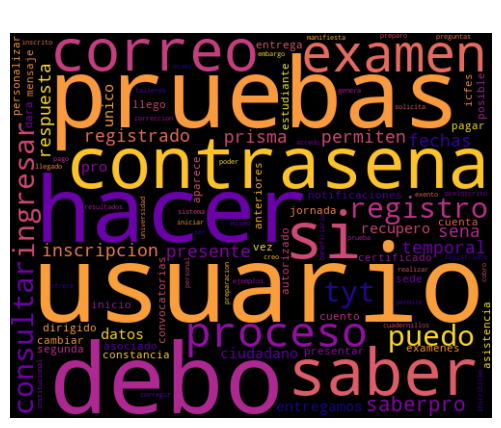

Nube de palabras - Respuestas


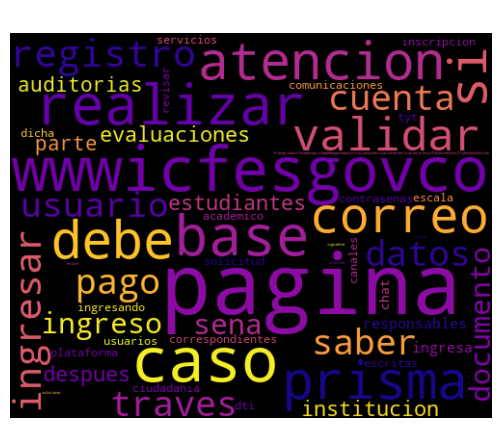

In [26]:
stop_words = set(stopwords.words("spanish"))

# 📌 2️⃣ Función para limpiar y tokenizar sin `word_tokenize()`
def tokenizar_y_filtrar(texto):
    tokens = re.findall(r'\b\w+\b', texto.lower())  # Extraer solo palabras
    tokens = [word for word in tokens if word not in stop_words]  # Filtrar stopwords
    return tokens

# 📌 3️⃣ Tokenizar preguntas y respuestas
tokens_preguntas = [token for pregunta in df_preguntas["Pregunta"] for token in tokenizar_y_filtrar(pregunta)]
tokens_respuestas = [token for respuesta in df_respuestas["Respuesta"] for token in tokenizar_y_filtrar(respuesta)]

# 📌 4️⃣ Contar la frecuencia de palabras
frecuencia_preguntas = Counter(tokens_preguntas)
frecuencia_respuestas = Counter(tokens_respuestas)

# 📌 5️⃣ Función para generar nubes de palabras
def generar_nube_palabras(frecuencia_palabras, titulo):
    wordcloud = WordCloud(
        width=500, height=400, 
        background_color="black", 
        colormap="plasma", 
        max_words=100
    ).generate_from_frequencies(frecuencia_palabras)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(titulo, fontsize=14, color="white")
    plt.show()

# 📌 6️⃣ Generar nubes de palabras para preguntas y respuestas
print("Nube de palabras - Preguntas")
generar_nube_palabras(frecuencia_preguntas, "Nube de Palabras - Preguntas")
print("Nube de palabras - Respuestas")
generar_nube_palabras(frecuencia_respuestas, "Nube de Palabras - Respuestas")

C:\Users\santi\AppData\Local\Temp\ipykernel_22072\1836645350.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frecuencias), y=list(palabras), palette="viridis")


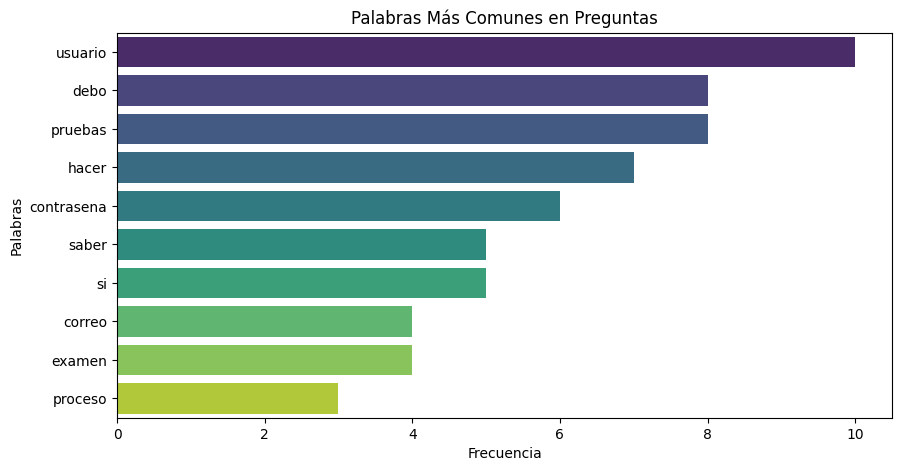

C:\Users\santi\AppData\Local\Temp\ipykernel_22072\1836645350.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frecuencias), y=list(palabras), palette="viridis")


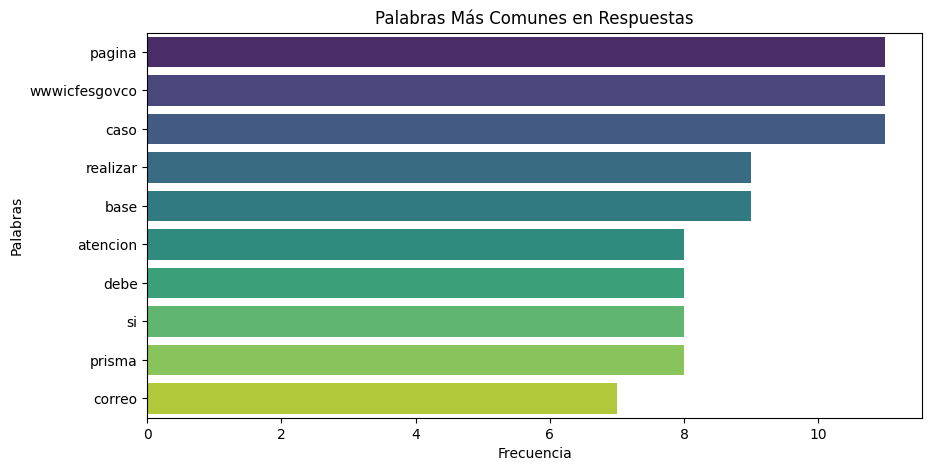

In [27]:
# 📌 5️⃣ Función para graficar palabras más comunes
def graficar_palabras_comunes(palabras_comunes, titulo):
    palabras, frecuencias = zip(*palabras_comunes)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(frecuencias), y=list(palabras), palette="viridis")
    plt.title(titulo)
    plt.xlabel("Frecuencia")
    plt.ylabel("Palabras")
    plt.show()

# 📌 6️⃣ Generar gráficos para preguntas y respuestas
graficar_palabras_comunes(top_preguntas, "Palabras Más Comunes en Preguntas")
graficar_palabras_comunes(top_respuestas, "Palabras Más Comunes en Respuestas")

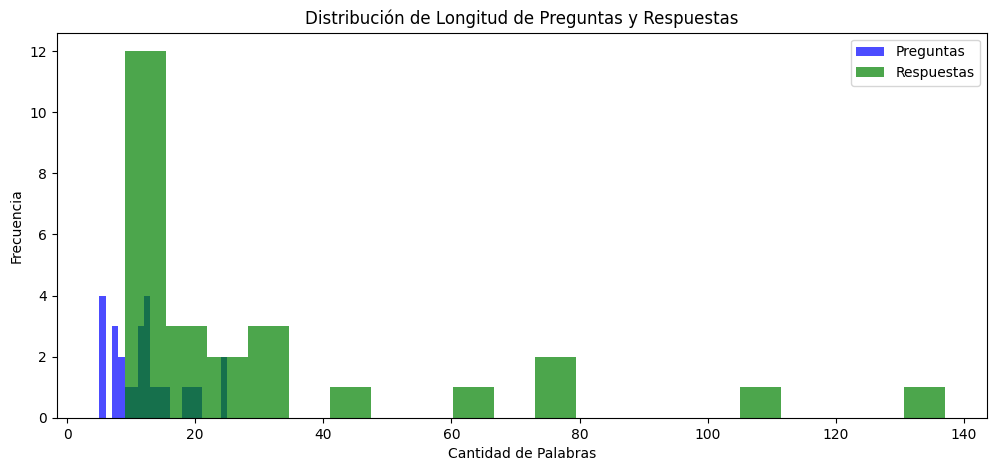

In [28]:
# Contar la cantidad de palabras en preguntas y respuestas
df_preguntas["Longitud_Pregunta"] = df_preguntas["Pregunta"].apply(lambda x: len(x.split()))
df_respuestas["Longitud_Respuesta"] = df_respuestas["Respuesta"].apply(lambda x: len(x.split()))

# Visualizar la distribución de longitudes
plt.figure(figsize=(12, 5))
plt.hist(df_preguntas["Longitud_Pregunta"], bins=20, alpha=0.7, label="Preguntas", color="blue")
plt.hist(df_respuestas["Longitud_Respuesta"], bins=20, alpha=0.7, label="Respuestas", color="green")
plt.xlabel("Cantidad de Palabras")
plt.ylabel("Frecuencia")
plt.title("Distribución de Longitud de Preguntas y Respuestas")
plt.legend()
plt.show()


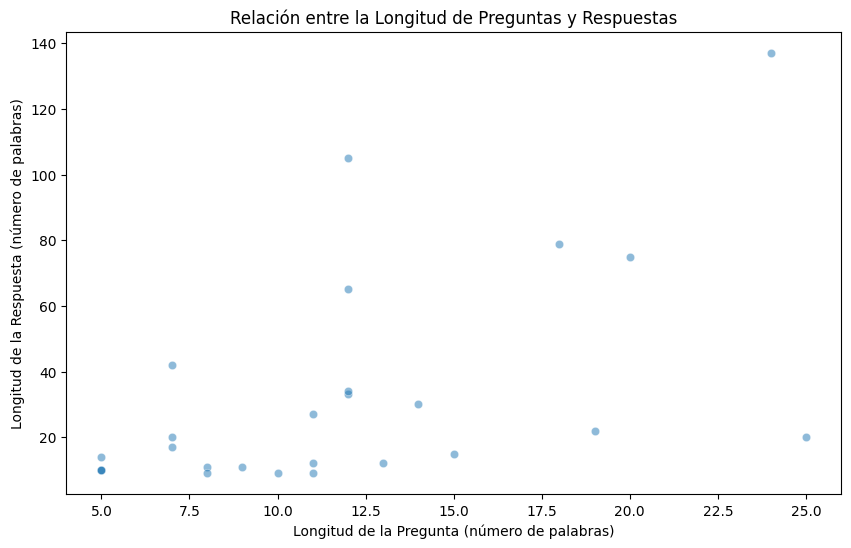

In [29]:
# Crear un scatterplot para ver la relación entre la longitud de preguntas y respuestas
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_preguntas["Longitud_Pregunta"], y=df_respuestas["Longitud_Respuesta"], alpha=0.5)
plt.xlabel("Longitud de la Pregunta (número de palabras)")
plt.ylabel("Longitud de la Respuesta (número de palabras)")
plt.title("Relación entre la Longitud de Preguntas y Respuestas")
plt.show()


In [35]:
from textblob import TextBlob

# Función para analizar sentimiento
def analizar_sentimiento(texto):
    return TextBlob(texto).sentiment.polarity  # Devuelve un valor entre -1 (negativo) y 1 (positivo)

# Aplicar análisis a preguntas y respuestas
df_preguntas["Sentimiento"] = df_preguntas["Pregunta"].apply(analizar_sentimiento)
df_respuestas["Sentimiento"] = df_respuestas["Respuesta"].apply(analizar_sentimiento)

# Mostrar resultados
print("\n📊 Distribución de sentimiento en preguntas:")
print(df_preguntas["Sentimiento"].describe())

print("\n📊 Distribución de sentimiento en respuestas:")
print(df_respuestas["Sentimiento"].describe())




📊 Distribución de sentimiento en preguntas:
count    26.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: Sentimiento, dtype: float64

📊 Distribución de sentimiento en respuestas:
count    26.000000
mean     -0.123077
std       0.294357
min      -0.800000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.000000
Name: Sentimiento, dtype: float64
